In [ ]:
#Loading Colab environment
import os
%load_ext autoreload

## Setup environment specific requirements and set paths. This is to accommodate
## running from Google Colab or from a local directory

if( os.path.isdir("/content") ):
  # Setup Specific to Google Colab Environment
 
    print("Running from Google Colab Environment")
    !pip install nilearn
    !pip install SimpleITK
    !pip install -q pydot
    !pip install graphviz
    !pip install Pillow     

    from google.colab import drive
    drive.mount('/content/drive')

  #%cd "/content/drive/My Drive/Colab Notebooks/Brats2019 AI"
    %cd "/content"

    sourceDirectory = %pwd
    sourceDirectory = sourceDirectory + "/"

   # %aimport XXXX
  # from XXXX import *
    
else:
  # Setup Specific to Local Jupyter Environment
  
    print('Running from Local Jupyter Environment')
 
    sourceDirectory = "./"

Running from Google Colab Environment
     |████████████████████████████████| 4.9 MB 13.7 MB/s 
     |████████████████████████████████| 48.4 MB 60 kB/s 
Mounted at /content/drive
/content


In [ ]:
#Loading important packages
import os,sys
import glob
import numpy as np
import random
from PIL import Image
import pandas as pd
import nibabel as nib
import imageio
import matplotlib
import matplotlib.image as mpimg
from nibabel.viewers import OrthoSlicer3D
from pathlib import Path
from matplotlib import pylab as plt
plt.style.use("ggplot")
%matplotlib inline
from skimage.util import img_as_ubyte
import imageio
from sklearn.preprocessing import minmax_scale
import cv2
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
#Unzip all images for modelling
!unzip "/content/drive/My Drive/Colab Notebooks/Brats2019 AI/all_images.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-141.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-142.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-143.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-144.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-145.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-146.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-147.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-148.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-149.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg_sliceno-150.png  
  inflating: /content/all_images/LGG-Sagital-BraTS19_TCIA13_618_1_seg

In [ ]:
#reading results from csv that was already processed on a local pc
pd.set_option("max_colwidth", None)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Brats2019 AI/brainmri_image_and_seg.csv', index_col=False)
df

,Image_dir,seg_dir,img_pixel_count,seg_pixel_count,Image Contrast
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,2.698186
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,2.698186
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-102.png,2209039,470359,2.698186
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-103.png,2185228,419286,2.698186
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-104.png,2131042,394959,2.698186
...,...,...,...,...,...
190954,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-95.png,1706414,1185358,2.698186
190955,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-96.png,1872545,1124575,2.698186
190956,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-97.png,1651053,1055237,2.698186
190957,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-98.png,1624300,1026346,2.698186


In [ ]:
#copying dataframe
df1 = df.copy()


In [ ]:
#Using full dataframe omited fraction
#df = df1.sample(frac = 1, replace=True)
df.shape

(190959, 5)

In [ ]:
l = 'C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png'
l1 = Path(l)
l1part = l1.parts
l1part

('C:\\Brain Tumor Validation\\Images_final\\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png',)

In [ ]:
#renaming paths from processed csv from local pc to colab
images = []
for path in df['Image_dir']:
  pths = path.split('\\')
  new_path = '/content' + '/' + 'all_images' + '/' + pths[3]
  images.append(new_path)
df['Image_dir'] = images


segment = []
for segpath in df['seg_dir']:
  pths = segpath.split('\\')
  new_path = '/content' + '/' + 'all_images' + '/' + pths[3]
  segment.append(new_path)
df['seg_dir'] = segment



In [ ]:
df

,Image_dir,seg_dir,img_pixel_count,seg_pixel_count,Image Contrast
0,/content/all_images/HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,/content/all_images/HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,2.698186
1,/content/all_images/HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,/content/all_images/HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,2.698186
2,/content/all_images/HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,/content/all_images/HGG-Axial-BraTS19_2013_17_1_seg_sliceno-102.png,2209039,470359,2.698186
3,/content/all_images/HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png,/content/all_images/HGG-Axial-BraTS19_2013_17_1_seg_sliceno-103.png,2185228,419286,2.698186
4,/content/all_images/HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png,/content/all_images/HGG-Axial-BraTS19_2013_17_1_seg_sliceno-104.png,2131042,394959,2.698186
...,...,...,...,...,...
190954,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-95.png,1706414,1185358,2.698186
190955,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-96.png,1872545,1124575,2.698186
190956,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-97.png,1651053,1055237,2.698186
190957,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png,/content/all_images/LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-98.png,1624300,1026346,2.698186


In [ ]:
#check if pathpaths were renamed appropriately 
idx = np.random.randint(0, len(df))
imagePath = os.path.join(df['Image_dir'].iloc[idx])
imagePath

'/content/all_images/HGG-Sagital-BraTS19_TCIA01_425_1_t1_sliceno-74.png'

In [ ]:
#resizing image to 240 x 240
import os,sys
from PIL import Image
def resizeimg(width, height):
    %cd  "path"
    # for each image in the current directory
    #path = '/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Images'
    for image in os.listdir(os.getcwd()):
        # open the image
        img = Image.open(image)        
        img.resize((width,height)).save(image)        
        img.close()
        
#resize image        
#resizeimg(240,240)

UNET Prep

In [ ]:
#function to review image dimensions
def print_imShape():
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(df['Image_dir'].iloc[idx])
    maskPath = os.path.join(df['seg_dir'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)

In [ ]:
#reviewing image dimensions
for i in range(20):
    print_imShape()

(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)
(240, 240, 3) (240, 240, 3)


In [ ]:
#function to review image segment as well as combination of the two
def plot_images():
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(df['Image_dir'].iloc[idx])
    maskPath = os.path.join(df['seg_dir'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[10,15])
    
    print(imagePath)
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    #plt.grid(True)
    plt.show()

/content/all_images/HGG-Coronal-BraTS19_CBICA_AUA_1_t1ce_sliceno-154.png


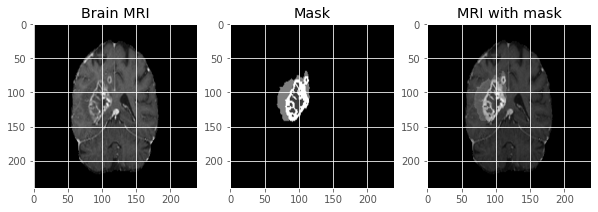

/content/all_images/HGG-Axial-BraTS19_CBICA_ASK_1_t1_sliceno-67.png


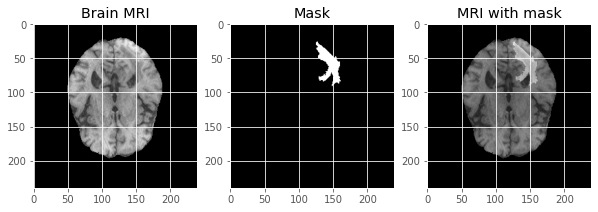

/content/all_images/LGG-Coronal-BraTS19_TCIA09_312_1_flair_sliceno-96.png


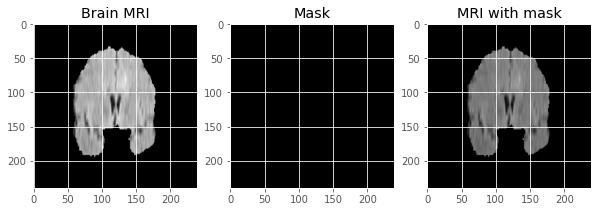

/content/all_images/HGG-Sagital-BraTS19_TCIA01_425_1_t1ce_sliceno-130.png


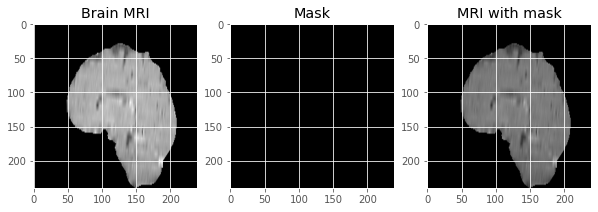

/content/all_images/HGG-Sagital-BraTS19_TCIA01_231_1_t2_sliceno-144.png


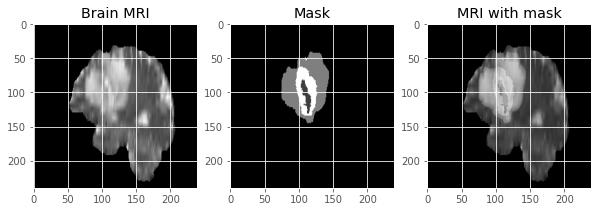

In [ ]:
#plotting 5 random images
for i in range(5):
    plot_images()

In [ ]:
#split the train and test data as 75% and 25% respectively
train , test = train_test_split(df, test_size=0.25, random_state=21)

In [ ]:
#defining model parameters
EPOCHS = 30
BATCH_SIZE = 32
ImgHieght = 240
ImgWidth = 240
Channels = 1

Data Generator

In [ ]:
#datagenerator defined to determine how images are handled
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

Train

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="Image_dir",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="seg_dir",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 143219 validated image filenames.
Found 143219 validated image filenames.


Validation

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="Image_dir",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="seg_dir",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')   

Found 47740 validated image filenames.
Found 47740 validated image filenames.


In [ ]:
#function to generate images from previous image generators above
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [ ]:
#yielding images from generators
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

Implementing UNET for segmentation

In [ ]:
#function to create 2 additional convolutional neural network layers
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
#defining unet architecture
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Corrected Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    

#IOU Coeffifficent
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
#specicify input, model parameters and then compile
input_img = Input((ImgHieght, ImgWidth, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, iou, precision,sensitivity,specificity])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 240, 240, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 240, 240, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 240, 240, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [ ]:
#set callbacks to prevent overfitting
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
#parameters set to prevent overfittingon each epoch
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [ ]:
#original = EPOCHS
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/30
4475/4475 [==============================] - 1252s 276ms/step - loss: 0.0651 - accuracy: 0.9623 - dice_coef: 0.2987 - iou: 0.1795 - precision: 0.3318 - sensitivity: 0.2678 - specificity: 0.9811 - val_loss: 0.0502 - val_accuracy: 0.9670 - val_dice_coef: 0.3942 - val_iou: 0.2460 - val_precision: 0.3829 - val_sensitivity: 0.3768 - val_specificity: 0.9802

Epoch 00001: val_loss improved from inf to 0.05017, saving model to model-brain-mri.h5
Epoch 2/30
4475/4475 [==============================] - 1220s 273ms/step - loss: 0.0445 - accuracy: 0.9647 - dice_coef: 0.4244 - iou: 0.2699 - precision: 0.3705 - sensitivity: 0.4309 - specificity: 0.9797 - val_loss: 0.0423 - val_accuracy: 0.9687 - val_dice_coef: 0.4686 - val_iou: 0.3065 - val_precision: 0.3801 - val_sensitivity: 0.4949 - val_specificity: 0.9793

Epoch 00002: val_loss improved from 0.05017 to 0.04227, saving model to model-brain-mri.h5
Epoch 3/30
4475/4475 [==============================] - 1219s 272ms/step - loss: 0.0814 - 

In [ ]:
#saving model
model.save('/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Models/BraTs2019mri1.h5')
model.save_weights('/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Models/BraTs2019mri1.hdf5')

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

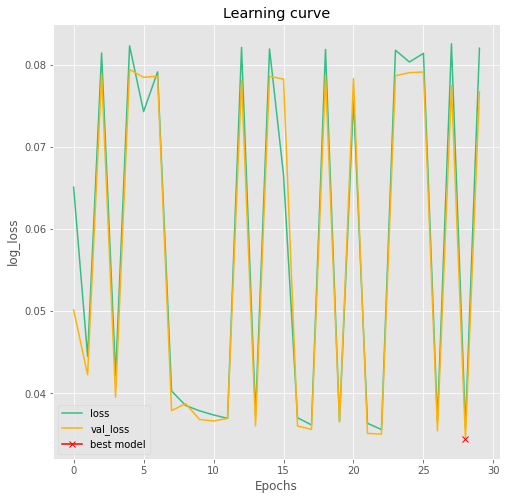

In [ ]:
#graph used to display learning rate specific to loss and validation loss
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

Prediction

In [ ]:
# load the best model
model.load_weights('model-brain-mri.h5')

In [ ]:
#evaluating model on validation data
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

1491/1491 [==============================] - 71s 47ms/step - loss: 0.0345 - accuracy: 0.9706 - dice_coef: 0.5400 - iou: 0.3703 - precision: 0.4246 - sensitivity: 0.6378 - specificity: 0.9785


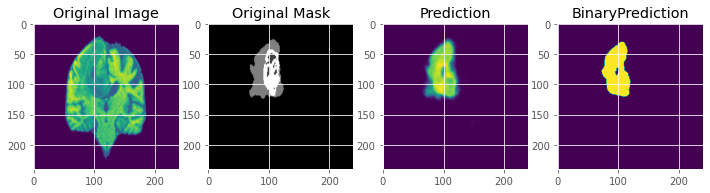

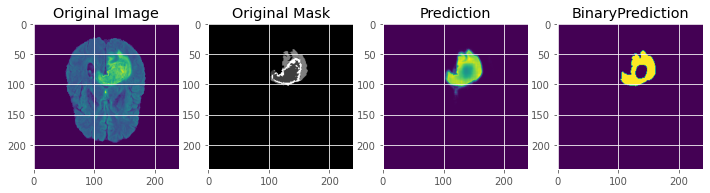

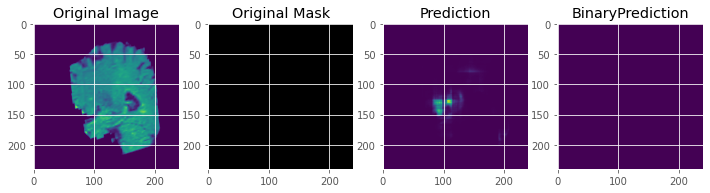

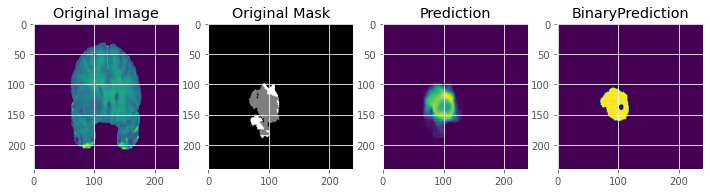

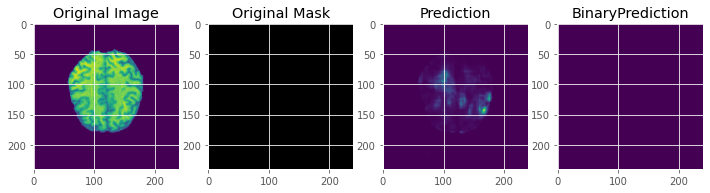

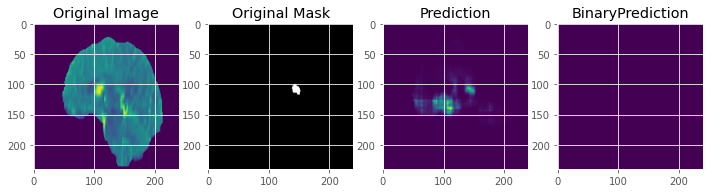

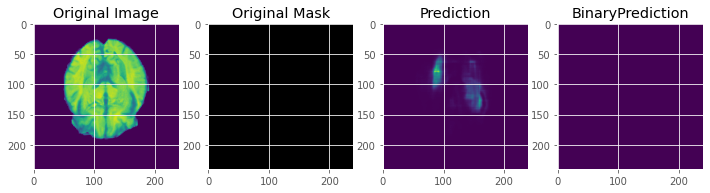

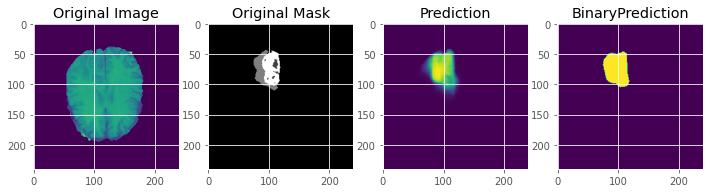

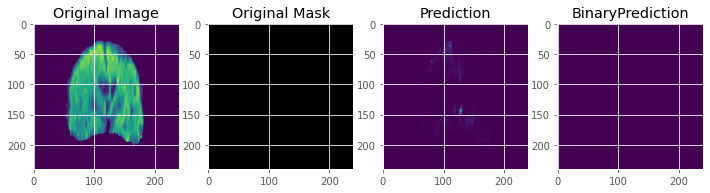

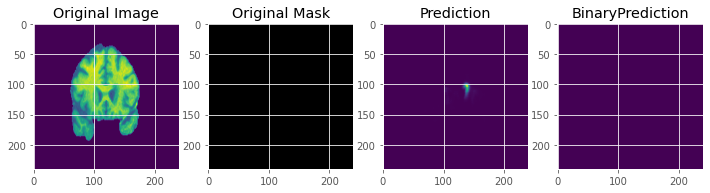

In [ ]:
#review prediction of segement vs orginal
for i in range(10):
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(df['Image_dir'].iloc[idx])
    maskPath = os.path.join(df['seg_dir'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, 1]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()